In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

## gather data df

In [2]:
pull_from_wandb = False
sample_name = "data/num_train_samples"
metric_name = "test/roc_auc"
temporal_metric_name = "test/temporal_roc_auc"
loss_name = "test/loss"
temporal_loss_name = "test/temporal_loss"
pretrained_names = [
    "nyutron (ours, clinical)",
    "web-wiki+bio+clinical",
    "web-wiki+bio",
    "web-wiki",
    "random-init",
    "lace+xgb",
]
data_types = ["unstructured", "structured"]
keep_cols = [sample_name, metric_name, temporal_metric_name, "pretrained", "data_type"]

In [3]:
if pull_from_wandb:
    legacy_df = pd.read_csv("raw_data/3b_lace_xgb.csv")
    legacy_df = legacy_df.rename(
        {
            "temporal test auc": temporal_metric_name,
            "same-time test auc": metric_name,
            "n_samples": sample_name,
        },
        axis=1,
    )
    legacy_df["pretrained"] = "lace+xgb"
    legacy_df["data_type"] = "structured"

In [4]:
if pull_from_wandb:
    data_df = pd.read_csv("raw_data/3b_lms.csv")
    keep_models = [
        "bio_new",
        "gatortron-og_new",
        "nyutron (ours)",
        "random_init_new",
        "web-wiki_new",
    ]
    data_df = data_df[data_df.pretrained.isin(keep_models)]
    rename_dict = {
        "bio_new": "web-wiki+bio",
        "gatortron-og_new": "web-wiki+bio+clinical",
        "random_init_new": "random-init",
        "web-wiki_new": "web-wiki",
        "nyutron (ours)": "nyutron (ours, clinical)",
    }
    data_df["pretrained"] = data_df["pretrained"].replace(rename_dict)
    data_df["data_type"] = "unstructured"

In [5]:
if pull_from_wandb:
    plot_df = pd.concat([data_df[keep_cols], legacy_df[keep_cols]], ignore_index=True)
    print(plot_df)
    print(np.unique(np.array(plot_df.pretrained)))
    print(plot_df[plot_df["pretrained"] == "random-init"][["pretrained", "data_type"]])

## Plot combined dfs

In [6]:
if pull_from_wandb:
    plot_df["pretrained"] = pd.Categorical(
        plot_df["pretrained"], categories=pretrained_names, ordered=True
    )
    plot_df = plot_df.sort_values(by="pretrained")
    print(plot_df[plot_df["pretrained"] == "random-init"][["pretrained", "data_type"]])
else:
    plot_df = pd.read_csv("raw_data/3b_plot.csv")
    plot_df["pretrained"] = pd.Categorical(
        plot_df["pretrained"], categories=pretrained_names, ordered=True
    )
    plot_df["data_type"] = pd.Categorical(
        plot_df["data_type"], categories=data_types, ordered=True
    )
    plot_df = plot_df.sort_values(by=["pretrained", "data_type"])

In [7]:
plt_conf = OmegaConf.load("nature.yaml")
slack = 5
single_col_width = 89 - slack
double_col_width = 183 - slack
height = 89 - slack


def mm_to_inch(mm):
    return mm / 25.4


print(plt_conf)

{'axes.labelsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, 'legend.fontsize': 7, 'font.size': 7, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial, Helvetica', 'mathtext.fontset': 'dejavusans', 'axes.linewidth': 0.5, 'grid.linewidth': 0.5, 'lines.linewidth': 1.0, 'lines.markersize': 3, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'svg.fonttype': 'none'}


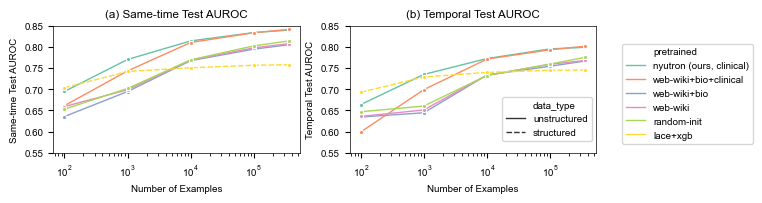

In [8]:
idx = ["a", "b"]
vals = [metric_name, temporal_metric_name]
plot_name = {
    metric_name: "Same-time Test AUROC",
    temporal_metric_name: "Temporal Test AUROC",
}
sns.color_palette("pastel")
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (mm_to_inch(double_col_width), mm_to_inch(height / 2))
fig = plt.figure()

# add subplots
handles = None
labels = None
for i, val in enumerate(vals, 1):
    name = plot_name[val]
    plt.subplot(1, 2, i)
    ax1 = sns.lineplot(
        x=sample_name,
        y=val,
        hue="pretrained",
        marker="o",  
        ci=None,
        style="data_type",
        estimator=np.median,
        palette=sns.color_palette("Set2", 6),
        data=plot_df,
    )
    ax1.set(xscale="log")
    if handles is None and labels is None:
        handles, labels = ax1.get_legend_handles_labels()
    ax1.get_legend().remove()
    plt.title(f"({idx[i-1]}) {name}")
    plt.ylim((0.55, 0.85))
    plt.xlabel("Number of Examples")
    plt.ylabel(name)

fig.legend(
    handles[:-3], labels[:-3], loc="upper right", ncol=1, bbox_to_anchor=(1.13, 0.8)
)
fig.legend(
    handles[-3:], labels[-3:], loc="lower right", ncol=1, bbox_to_anchor=(0.9, 0.15)
)
plt.show()

# Start here for cache

In [9]:
groups = plot_df[[sample_name, temporal_metric_name, "pretrained"]].groupby(
    [sample_name, "pretrained"]
)
medians = groups.median().reset_index()
medians

,data/num_train_samples,pretrained,test/temporal_roc_auc
0,100,"nyutron (ours, clinical)",0.663789
1,100,web-wiki+bio+clinical,0.599145
2,100,web-wiki+bio,0.634355
3,100,web-wiki,0.635807
4,100,random-init,0.646827
5,100,lace+xgb,0.692711
6,1000,"nyutron (ours, clinical)",0.734697
7,1000,web-wiki+bio+clinical,0.698871
8,1000,web-wiki+bio,0.644432
9,1000,web-wiki,0.651092


In [10]:
def get_examples(pretrained, auc, eps=0.005):
    tmp = medians[medians["pretrained"] == pretrained]
    better = tmp[tmp[temporal_metric_name] >= auc - eps]
    return better.head(1)


threshold = 0.75
clinical_75 = get_examples("nyutron (ours, clinical)", threshold)
random_75 = get_examples("random-init", threshold)
highlight_75 = pd.concat([clinical_75, random_75], ignore_index=True)
highlight_75

,data/num_train_samples,pretrained,test/temporal_roc_auc
0,10000,"nyutron (ours, clinical)",0.772187
1,100000,random-init,0.759115


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


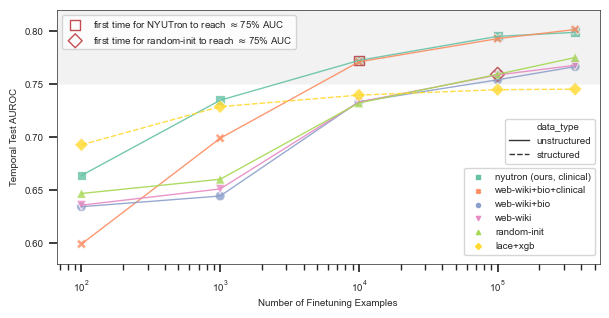

In [16]:
from textwrap import fill

marker_size = 50
sns.set(style="white")
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (mm_to_inch(double_col_width), mm_to_inch(height))
# plt.rcParams['xtick.major.size'] = 20
# plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
fig = plt.figure()
ax = sns.lineplot(
    x=sample_name,
    y=temporal_metric_name,
    hue="pretrained",
    err_style="bars",
    alpha=0.9,  
    ci=None,
    style="data_type",
    data=plot_df,
    estimator=np.median,
    palette=sns.color_palette("Set2", 6),
)
ax.set(xscale="log")
ax.get_legend().remove()
ax = sns.scatterplot(
    x=sample_name,
    y=temporal_metric_name,
    s=marker_size,
    alpha=0.8,
    style="pretrained",
    markers=[",", "X", "o", "v", "^", "D"],
    data=medians,
    hue="pretrained",
    palette=sns.color_palette("Set2", 6),
)
handles_markers, labels_markers = ax.get_legend_handles_labels()
ax.get_legend().remove()
clinical_ax = plt.scatter(
    clinical_75[sample_name],
    clinical_75[temporal_metric_name],
    s=marker_size,
    facecolors="none",
    edgecolors="r",
    marker=",",
) 
random_ax = plt.scatter(
    random_75[sample_name],
    random_75[temporal_metric_name],
    s=marker_size,
    facecolors="none",
    edgecolors="r",
    marker="D",
)  
plt.xlabel("Number of Finetuning Examples")
plt.ylabel(name)

fig.legend(
    handles_markers[-6:],
    labels_markers[-6:],
    loc="lower right",
    ncol=1,
    bbox_to_anchor=(0.9, 0.125),
)
fig.legend(
    handles[-3:], labels[-3:], loc="lower right", ncol=1, bbox_to_anchor=(0.9, 0.4)
)
plt.legend(
    (clinical_ax, random_ax),
    (
        fill(r"first time for NYUTron to reach $\approx$75% AUC", 50),
        fill(r"first time for random-init to reach $\approx$75% AUC", 55),
    ),
    scatterpoints=1,
    loc="upper left",
    ncol=1,
)
plt.axhspan(ymin=0.75, ymax=0.85, facecolor="grey", alpha=0.1)
plt.ylim([0.58, 0.82])
plt.savefig(
    "AIP_plots/3b.svg", bbox_inches="tight", format="svg", dpi=300, transparent=True
)
plt.savefig(
    "AIP_plots/3b.pdf", bbox_inches="tight", format="pdf", dpi=300, transparent=True
)
plt.savefig(
    "AIP_plots/3b.eps", bbox_inches="tight", format="eps", dpi=300, transparent=True
)

In [12]:
medians

,data/num_train_samples,pretrained,test/temporal_roc_auc
0,100,"nyutron (ours, clinical)",0.663789
1,100,web-wiki+bio+clinical,0.599145
2,100,web-wiki+bio,0.634355
3,100,web-wiki,0.635807
4,100,random-init,0.646827
5,100,lace+xgb,0.692711
6,1000,"nyutron (ours, clinical)",0.734697
7,1000,web-wiki+bio+clinical,0.698871
8,1000,web-wiki+bio,0.644432
9,1000,web-wiki,0.651092


In [13]:
stds = groups.std().reset_index()
stds

,data/num_train_samples,pretrained,test/temporal_roc_auc
0,100,"nyutron (ours, clinical)",0.065740
1,100,web-wiki+bio+clinical,0.042593
2,100,web-wiki+bio,0.081964
3,100,web-wiki,0.095580
4,100,random-init,0.094292
5,100,lace+xgb,0.055082
6,1000,"nyutron (ours, clinical)",0.004433
7,1000,web-wiki+bio+clinical,0.026843
8,1000,web-wiki+bio,0.094628
9,1000,web-wiki,0.062968


In [14]:
plot_df.to_csv("raw_data/3b_plot.csv")